In [21]:
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize

def plane(grid_shape, point, normal):
    point = np.array(point)
    normal = np.array(normal)
    d = -point.dot(normal)
    xx, yy = np.meshgrid(range(grid_shape[0]), range(grid_shape[1]))

    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    z = z.astype(int)

    arr = np.array([[x, y, z[x, y]] for x in range(grid_shape[0]) for y in range(grid_shape[1])])

    plane_labelmap = np.zeros(cyl.shape)

    for r in arr:
        if r[2] in range(grid_shape[2]):
            plane_labelmap[r[0], r[1], r[2]] = 1
    plane_labelmap = plane_labelmap.astype(int)
    
    return plane_labelmap, (xx, yy, z)

def enum_directions(a, x, y, z):
    cube = a[x-1:x+2, y-1:y+2, z-1:z+2]
    cube[1,1,1] = 0
    dirs = (np.stack(np.where(cube == 1))-1).T
    res = []
    for d in dirs:
        if (-d).tolist() not in res:
            res.append(d.tolist())
    return np.array(res)

def walk_bound(a, point, direction):
    i = 1
    p = np.array(point)
    d = np.array(direction)
    while True:
        try:
            idx =  p + i * d
            t_val = a[idx[0],idx[1],idx[2]]
            if t_val != 1:
                return idx -  d
            i = i + 1
        except Exception as e:
            return idx - d

def rot_area(n_vox, pixdim, n):
    n = np.array(n)
    n = n / np.linalg.norm(n)
    print(n, np.sin(np.arccos(n[2])), n_vox)
    if list(n) == [0,0,1]:
        return n_vox * pixdim[0] * pixdim[1]
    if list(n) == [0,1,0]:
        return n_vox * pixdim[0] * pixdim[2]
    if list(n) == [1,0,0]:
        return n_vox * pixdim[1] * pixdim[2]
    if n[0] == 0 or n[1] == 0:
        return n_vox * pixdim[0] * pixdim[1] / np.abs(n[2])
    return n_vox * pixdim[0] * pixdim[1] / np.abs(n[2] / n[0] / np.sin(np.arccos(n[2])))

In [48]:
# find vessel and skeleton labelmap
cyl = np.zeros((128,128,128))
for i in range(cyl.shape[2]):
    off = i#np.sin(i / 128 * 2*np.pi) * 40
    rr, cc = draw.disk((64 + off/5, 64 + off/2), 3, shape=cyl.shape[0:2])
    cyl[rr, cc, i] = 1

skel = skeletonize(cyl.astype(np.uint8))
# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx][::3]
one[1] = one_pos[1][idx][::3]
one[2] = one_pos[2][idx][::3]
one = np.stack(one)

distances = []
test = []
areas = []
pixdim = [1,1,1]

for i in range(2, one.shape[1]-2):
    # find plane
    normal = ((one[:, i] - one[:, i-2])/2 + (one[:, i] - one[:,i-1]) + (one[:, i+1] - one[:,i]) + (one[:, i+2] - one[:,i])/2)/4
    normal = normal / np.linalg.norm(normal)
    p, t = plane(cyl.shape, one[:, i], normal)
    intersection = p * cyl
    test.append(intersection)
    s = pixdim[0] * np.sqrt(1 + ((pixdim[2]/pixdim[0])**2 - 1)*normal[2])
    areas.append(np.sum(intersection)*pixdim[0]*pixdim[1]*pixdim[2] / s)
    # enum directions
    
    #
    #dirs = enum_directions(intersection, *one[:, i])
    #  
    #dist = []
    #for d in dirs:
    #    p1 = walk_bound(intersection, one[:, i], d)
    #    p2 = walk_bound(intersection, one[:, i], -d)
    #    dist.append(np.linalg.norm(p1 - p2))
    #distances.append((np.mean(dist), np.std(dist)))

print(areas)

[23.0, 22.0, 24.0, 21.0, 21.0, 23.0, 23.0, 22.0, 23.0, 22.0, 21.0, 23.0, 25.0, 24.0, 23.0, 26.0, 22.0, 23.0, 23.0, 23.0, 21.0, 23.0, 23.0, 22.0, 22.0, 23.0, 26.0, 22.0, 22.0, 21.0, 22.0, 22.0, 23.0, 23.0, 22.0, 22.0, 15.0, 4.0]


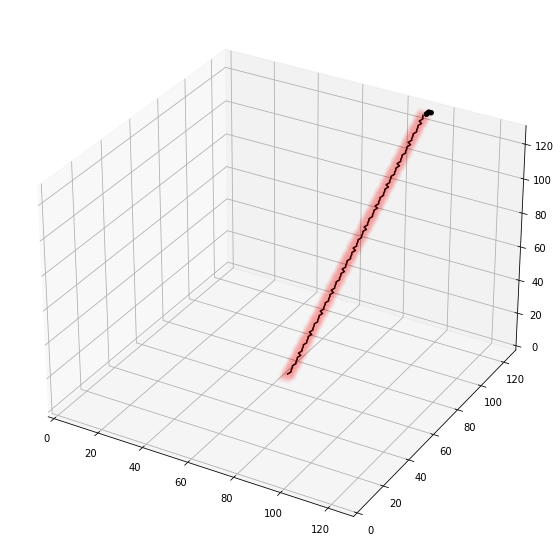

28.274333882308138


In [50]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# vessel
pos = np.where(cyl==1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.01)

# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx]
one[1] = one_pos[1][idx]
one[2] = one_pos[2][idx]
one = np.stack(one)
ax.plot(one[0], one[1], one[2], c='black')

ax.set_xlim(0, cyl.shape[0])
ax.set_ylim(0, cyl.shape[1])
ax.set_zlim(0, cyl.shape[2])

el = -1
p_reg = np.where(test[el] == 1)
ax.scatter(p_reg[0], p_reg[1], p_reg[2], alpha=1, c='black')

plt.show()


print(np.pi * 3 **2)

In [ ]:


dirs = enum_directions(inter, *sp)

def nearest_nonzero_idx(a,x,y,z):
    tmp = a[x,y,z]
    a[x,y,z] = 0
    i, j, k = np.nonzero(a)
    a[x,y,z] = tmp
    min_idx = ((i - x)**2 + (j - y)**2 + (k-z)**2).argmin()
    return [i[min_idx], j[min_idx], k[min_idx]]

nearest = nearest_nonzero_idx(inter, *sp)
d = np.array(nearest) - np.array(sp)


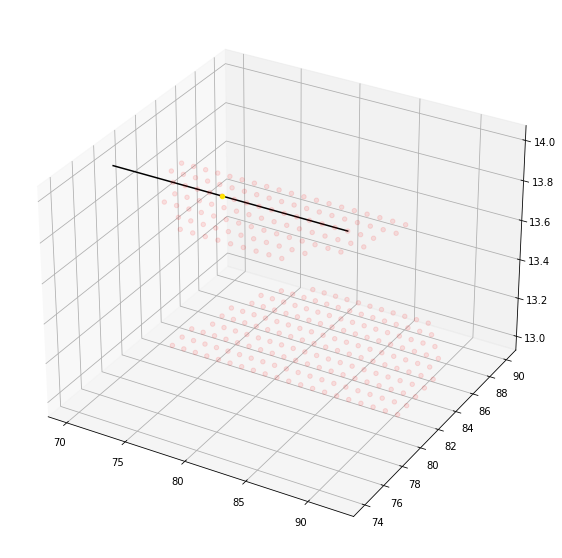

In [ ]:


line = [np.array(sp) + i*dirs[1] for i in range(-10, 10)]


inter = p * cyl

pos = np.where(inter == 1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.1)
ax.scatter(79 ,78 ,14, c='yellow')

pos = np.array(line).T

ax.plot(pos[0], pos[1], pos[2], c='black', alpha=1)


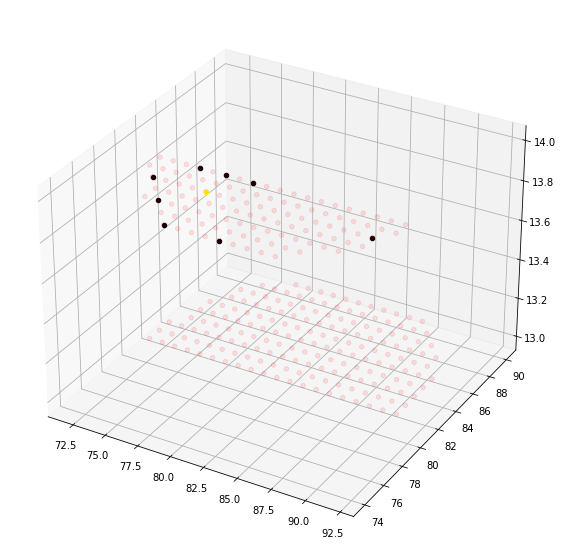

In [ ]:



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

pos = np.where(inter == 1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.1)
ax.scatter(*sp, c='yellow')
for d in dirs:
    p1 = walk_bound(inter, sp, d)
    p2 = walk_bound(inter, sp, -d)
    ax.scatter(*p1, c='black', alpha=1)
    ax.scatter(*p2, c='black', alpha=1)

        

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# vessel
pos = np.where(cyl==1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.01)

# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx]
one[1] = one_pos[1][idx]
one[2] = one_pos[2][idx]
one = np.stack(one)
ax.plot(one[0][::3], one[1][::3], one[2][::3], c='black')

ax.set_xlim(0, cyl.shape[0])
ax.set_ylim(0, cyl.shape[1])
ax.set_zlim(0, cyl.shape[2])

plt.show()